# Training Two Tower model
In this notebook, we use the preprocessed data prepared in the `data_preprocessing.ipynb` notebook to train the Two-Tower model for our recommendation system.

## 1. Create the Dataset and DataLoader
The data is currently stored in CSV files and isn't directly compatible with PyTorch. We need to create a custom Dataset class to load the data and then use a DataLoader to handle batching and shuffling.

We also define a custom collate function to handle the batching of variable-length impressions. To do this, we will pad the item features and labels to the length of the longest impression in the batch.

See the `dataset.py` file for the implementation of the `RecommendationDataset` class and the `impression_collate_fn` function.

In [1]:
import torch
from torch.utils.data import DataLoader
from dataset import RecommendationDataset, impression_collate_fn

# Create dataset and dataloader
print("Creating train dataset")
train_dataset = RecommendationDataset(
    'data/large/train/processed/user_features.csv',
    'data/large/train/processed/item_features.csv',
    'data/large/train/processed/two_tower_interactions.csv',
    max_negs_and_pos=(5, 1)
)
print("Creating val dataset")
val_dataset = RecommendationDataset(
    'data/large/dev/processed/user_features.csv',
    'data/large/dev/processed/item_features.csv',
    'data/large/dev/processed/two_tower_interactions.csv',
    max_negs_and_pos=(5, 1)
)

Creating train dataset
Loading user csv
Loading items csv
Loading interactions csv
Done loading data


100%|██████████| 2232748/2232748 [01:37<00:00, 22787.77it/s]


Creating user2idx dict
Creating item2idx dict
Creating val dataset
Loading user csv
Loading items csv
Loading interactions csv
Done loading data


100%|██████████| 376471/376471 [00:15<00:00, 24448.31it/s]


Creating user2idx dict
Creating item2idx dict


In [2]:
train_dataset.max_negs_and_pos = None
val_dataset.max_negs_and_pos = None

In [3]:
print("Creating train loader")
train_loader = DataLoader(
    train_dataset,
    batch_size=512,
    shuffle=True,
    collate_fn=impression_collate_fn,
    pin_memory=True,
    num_workers=48,
    prefetch_factor=16
)

print("Creating val loader")
val_loader = DataLoader(
    val_dataset,
    batch_size=512,
    shuffle=False,
    collate_fn=impression_collate_fn,
    pin_memory=True,
    num_workers=48,
    prefetch_factor=16
)

Creating train loader
Creating val loader


## 2. Define the Two-Tower Model
Now, we define the Two-Tower model architecture. This model consists of two separate neural networks (towers) for processing user and item features, respectively. The outputs of these towers are embeddings in a shared latent space, which are then used to compute the similarity score for recommendation.

See `two_tower_model.py` for the implementation.

## 3. Loss
We now design the loss function. There are multiple ways to implement the loss for a Two-Tower model. A common one is InfoNCE loss which we will use here. Unfortunately, InfoNCE doesn't natively handle multi-positive impressions like we have in our dataset, so we will need to adapt it accordingly. Indeed, the standard InfoNCE loss is defined as:
\begin{equation}
L = - \log \frac{\exp(\text{sim}(u, i^+))}{\exp(\text{sim}(u, i^+)) + \sum_{j} \exp(\text{sim}(u, i_j^-))}
\end{equation}
Where:
- $u$ is the user embedding.
- $i^+$ is a positive item embedding.
- $i_j^-$ are negative item embeddings.
- $\text{sim}(\cdot, \cdot)$ is a similarity function (e.g., dot product or cosine similarity).

To adapt this for multiple positive items, we can modify the numerator to sum over all positive items for a given user. The adapted loss becomes:
\begin{equation}
L = - \log \frac{\sum_{k} \exp(\text{sim}(u, i_k^+))}{\sum_{k} \exp(\text{sim}(u, i_k^+)) + \sum_{j} \exp(\text{sim}(u, i_j^-))}
\end{equation}

Regarding the similarity function, since our embeddings are normalized, dot product is preferred for its computational efficiency.

Also, it is common to introduce a temperature parameter $\tau$ to scale the similarity scores, which can help in controlling the concentration level of the distribution. The final loss function with temperature scaling is:
\begin{equation}
L = - \log \frac{\sum_{k} \exp(\text{sim}(u, i_k^+) / \tau)}{\sum_{k} \exp(\text{sim}(u, i_k^+) / \tau) + \sum_{j} \exp(\text{sim}(u, i_j^-) / \tau)}
\end{equation}

In [13]:
import torch.nn as nn


class InfoNCE(nn.Module):
    def __init__(self, temperature: float = 0.1):
        super(InfoNCE, self).__init__()
        self.temperature = temperature

    def forward(self, scores: torch.Tensor, labels: torch.Tensor, mask: torch.Tensor) -> torch.Tensor:
        # 1. Mask out the padding scores
        # By setting them to -inf, their exp will be 0 and won't contribute to the loss
        scores = scores.masked_fill(~mask, float('-inf'))

        # 2. Apply temperature scaling
        scores = scores / self.temperature

        # 3. Compute log-sum-exp for denominator
        log_sum_exp = torch.logsumexp(scores, dim=1)  # (Batch,)

        # 4. Compute log-sum-exp for numerator (only positive items)
        positive_scores = scores.masked_fill(labels == 0, float('-inf'))
        log_sum_exp_positive = torch.logsumexp(positive_scores, dim=1)  # (Batch,)

        # 5. Compute the loss
        loss = - (log_sum_exp_positive - log_sum_exp)  # (Batch,)
        loss = loss.mean()  # Average over the batch

        return loss

## 4. Training Loop

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [15]:
import tqdm.notebook as tqdm
from torchmetrics.retrieval import RetrievalRecall
from two_tower_model import TwoTowerModel

# Define metric
recallAtK = RetrievalRecall(top_k=2).to(device)

def compute_metric(metric, scores, labels, device=device):
    B, N = scores.shape
    indexes = torch.arange(B).unsqueeze(1).expand(B, N).to(device)
    return metric(
        scores,
        labels.bool(),
        indexes=indexes
    )

def model_eval(model, loader, infoNCE, metric, avg_metric_over, pbar=None):
    model.eval()
    running_loss = 0.0
    running_metric = 0.0
    with torch.no_grad():
        for i, (user_features, item_embeddings, item_subcategory, labels, masks) in enumerate(loader):
            user_features = user_features.to(device, non_blocking=True)
            item_embeddings = item_embeddings.to(device, non_blocking=True)
            item_subcategory = item_subcategory.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            scores = model(user_features, item_embeddings, item_subcategory)
            loss = infoNCE(scores, labels, masks)

            if pbar: pbar.update(1)
            running_loss += loss.detach()

            if i < avg_metric_over:
                running_metric += compute_metric(metric, scores, labels)
            

    return (running_loss / len(loader)).item(), (running_metric / avg_metric_over).item()

def train_model(
        model: TwoTowerModel,
        train_loader: DataLoader,
        val_loader: DataLoader,
        optimizer: torch.optim.Optimizer,
        infoNCE: InfoNCE,
        num_epochs: int = 5,
        device: torch.device = device,
        history_step: int = 200,
        metric = recallAtK,
        early_stopping_patience: int = 20,
        avg_metric_over: int = 10
    ):
    number_of_training_steps = num_epochs * len(train_loader)
    number_of_validation_steps = (num_epochs + 1) * len(val_loader)  # +1 for initial loss

    model.to(device)
    pbar = tqdm.tqdm(total=number_of_training_steps + number_of_validation_steps, unit="step")

    initial_loss, initial_metric = model_eval(model, val_loader, infoNCE, metric, avg_metric_over, pbar=pbar)
    history = {
        'train_loss': [initial_loss],
        'val_loss': [initial_loss],
        'train_metric': [initial_metric],
        'val_metric': [initial_metric]
    }

    # Training loop
    avg_val_loss = float('inf')
    avg_train_loss = float('inf')
    avg_train_metric = float('-inf')
    avg_val_metric = float('-inf')
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        running_train_metric_score = 0.0
        for i, (user_features, item_embeddings, item_subcategory, labels, masks) in enumerate(train_loader):
            user_features = user_features.to(device, non_blocking=True)
            item_embeddings = item_embeddings.to(device, non_blocking=True)
            item_subcategory = item_subcategory.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            optimizer.zero_grad()
            scores = model(user_features, item_embeddings, item_subcategory)
            loss = infoNCE(scores, labels, masks)
            loss.backward()
            optimizer.step()

            pbar.update(1)
            running_train_loss += loss.detach()

            if (i + 1) % history_step >= history_step - avg_metric_over:
                running_train_metric_score += compute_metric(metric, scores, labels)

            if (i + 1) % history_step == 0:
                # Update progress bar statistics
                avg_train_loss = (running_train_loss / history_step).item()
                avg_train_metric = (running_train_metric_score / avg_metric_over).item()

                history['train_metric'].append(avg_train_metric)
                history['train_loss'].append(avg_train_loss)
                pbar.set_postfix_str(f"Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Train metric: {avg_train_metric:.4f} - Val metric: {avg_val_metric:.4f}")
                running_train_loss = 0.0
                running_train_metric_score = 0.0

                if len(history['train_loss']) >= early_stopping_patience:
                    tl = history['train_loss']
                    if min(list(range(1, early_stopping_patience+1)), key=lambda x: tl[-x]) == early_stopping_patience:
                        # we have not improved for early_stopping_patience iterations, stop early
                        print(f"Early stopped as we have not improved for {early_stopping_patience} logged iterations")
                        pbar.close()
                        return history
                        

        # Evaluation phase
        avg_val_loss, avg_val_metric = model_eval(model, val_loader, infoNCE, metric, avg_metric_over, pbar=pbar)

        # Update progress bar statistics
        pbar.set_postfix_str(f"Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f} - Train metric: {avg_train_metric:.4f} - Val metric: {avg_val_metric:.4f}")

        # Save losses and metric to history
        history['val_loss'].append(avg_val_loss)
        history['val_metric'].append(avg_val_metric)

    pbar.close()
    return history

## 5. Run the Training

In [17]:
model = TwoTowerModel()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
infoNCE = InfoNCE(temperature=0.07)
history = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    infoNCE,
    num_epochs=4,
    device=device
)

  0%|          | 0/21124 [00:00<?, ?step/s]

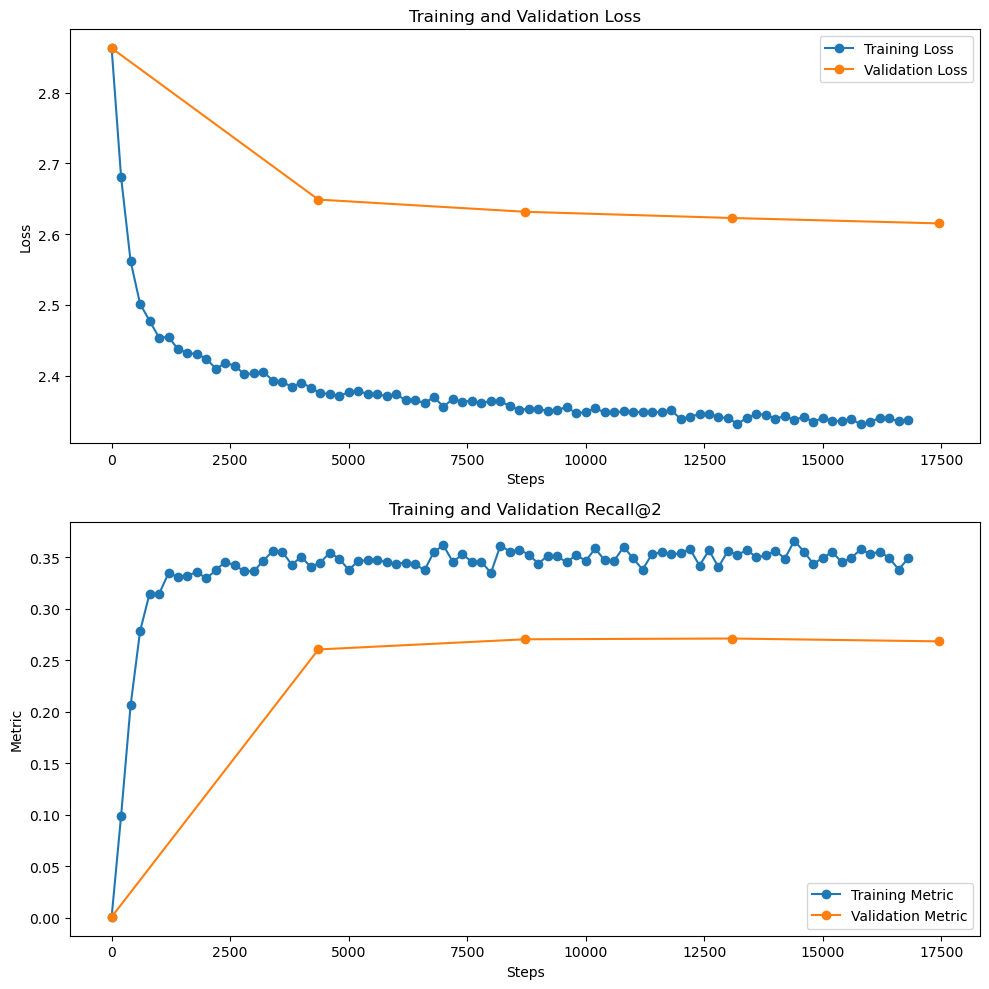

In [18]:
import matplotlib.pyplot as plt

def logged_steps_to_steps(logged_step, history_step=200):
    return logged_step * history_step

def epochs_to_steps(epoch, loader):
    return epoch * len(loader)

steps_train = [logged_steps_to_steps(e) for e in range(len(history['train_loss']))]
steps_val = [epochs_to_steps(e, train_loader) for e in range(len(history['val_loss']))]

# Plot training and validation loss
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(steps_train, history['train_loss'], 'o-', label='Training Loss')
plt.plot(steps_val, history['val_loss'], 'o-',  label='Validation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(steps_train, history['train_metric'], 'o-', label='Training Metric')
plt.plot(steps_val, history['val_metric'], 'o-',  label='Validation Metric')
plt.xlabel('Steps')
plt.ylabel('Metric')
plt.title('Training and Validation Recall@2')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
torch.save(model.state_dict(), './saved_states/tt_model.pt')

In [20]:
import json


with open("saved_states/history_tt_model.json", "w") as json_file:
    json.dump(history, json_file, indent=4)